In [1]:
from keras import preprocessing
from tensorflow.keras.optimizers import Adam
import tensorflow as tf
import random
from tensorflow.keras.applications.resnet50 import ResNet50
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import classification_report, confusion_matrix

from tensorflow.keras.applications.resnet50 import preprocess_input
from tensorflow.keras import layers

In [2]:
random_seed = 42
np.random.seed(random_seed)

In [28]:
train_data_dir = './data_split/train'
test_data_dir = './data_split/test'

img_size = (224, 224)
batch_size = 32

train_ds = preprocessing.image_dataset_from_directory(
    train_data_dir,
    validation_split=0.3,
    subset='training',
    seed=random_seed,
    label_mode='categorical',
    image_size=img_size,
    batch_size=batch_size,
    shuffle=True, 
    crop_to_aspect_ratio=True
)

val_ds = preprocessing.image_dataset_from_directory(
    train_data_dir,
    validation_split=0.3,
    subset='validation',
    seed=random_seed,
    label_mode='categorical',
    image_size=img_size,
    batch_size=batch_size,
    shuffle=True, 
    crop_to_aspect_ratio=True
)

test_ds = preprocessing.image_dataset_from_directory(
    test_data_dir,
    label_mode='categorical',
    image_size=img_size,
    batch_size=batch_size,
    shuffle=True,
    crop_to_aspect_ratio=True
)

class_names = train_ds.class_names

#train_ds = train_ds.map(lambda x, y: (preprocess_input(x), y))
#val_ds = val_ds.map(lambda x, y: (preprocess_input(x), y))
#test_ds = test_ds.map(lambda x, y: (preprocess_input(x), y))

Found 1545 files belonging to 3 classes.
Using 1082 files for training.
Found 1545 files belonging to 3 classes.
Using 463 files for validation.
Found 517 files belonging to 3 classes.


### Evaluation methods

In [31]:
def predict_test_data(model, test_data):
    true_labels = []
    pred_labels = []
    
    for images, labels in test_data:
        preds = model.predict(images)
        true_labels.extend(np.argmax(labels.numpy(), axis=1))
        pred_labels.extend(np.argmax(preds, axis=1))
    return true_labels, pred_labels

In [29]:
def make_classification_report(true_labels, pred_labels):
    print(classification_report(true_labels, pred_labels, target_names=class_names))

In [30]:
def make_confusion_matrix(true_labels, pred_labels):
    m = confusion_matrix(true_labels, pred_labels)
    plt.figure(figsize=(8, 8))
    sns.heatmap(m, annot=True, fmt='d', xticklabels=class_names, yticklabels=class_names, cmap='Blues')
    plt.xlabel('Predicted')
    plt.ylabel('True')
    plt.title('Confusion Matrix')
    plt.show()

In [ ]:
def plot_loss(history):
    plt.plot(history.history['loss'], label='loss')
    plt.plot(history.history['val_loss'], label='val_loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()
    plt.show()
    

In [ ]:
def plot_accuracy(history):
    plt.plot(history.history['accuracy'], label='accuracy')
    plt.plot(history.history['val_accuracy'], label='val_accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.legend()
    plt.show()
    

### Base model

Our base model is a plain ResNet50 model which is initialized with random weights and therefore has no prior knowledge of any images.

In [16]:
# Build model from scratch (random init)
base_model = ResNet50(include_top=True, weights=None, input_shape=(224, 224, 3), classes=len(class_names)) # include_top=True adds the classification layer

base_model.compile(
    optimizer=Adam(),
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

base_model.summary()

In [5]:
history = base_model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=10
)


Epoch 1/10
49/49 ━━━━━━━━━━━━━━━━━━━━ 280s 5s/step - accuracy: 0.7538 - loss: 1.2352 - val_accuracy: 0.5358 - val_loss: 2.2100
Epoch 2/10
49/49 ━━━━━━━━━━━━━━━━━━━━ 227s 5s/step - accuracy: 0.8835 - loss: 0.6819 - val_accuracy: 0.8956 - val_loss: 421.5759
Epoch 3/10
49/49 ━━━━━━━━━━━━━━━━━━━━ 225s 5s/step - accuracy: 0.8909 - loss: 0.4270 - val_accuracy: 0.8956 - val_loss: 13.7577
Epoch 4/10
49/49 ━━━━━━━━━━━━━━━━━━━━ 230s 5s/step - accuracy: 0.9005 - loss: 0.4089 - val_accuracy: 0.8956 - val_loss: 10.9692
Epoch 5/10
49/49 ━━━━━━━━━━━━━━━━━━━━ 232s 5s/step - accuracy: 0.8968 - loss: 0.3081 - val_accuracy: 0.8723 - val_loss: 0.3449
Epoch 6/10
49/49 ━━━━━━━━━━━━━━━━━━━━ 218s 4s/step - accuracy: 0.9140 - loss: 0.3002 - val_accuracy: 0.8743 - val_loss: 0.3596
Epoch 7/10
49/49 ━━━━━━━━━━━━━━━━━━━━ 224s 5s/step - accuracy: 0.9181 - loss: 0.2678 - val_accuracy: 0.8008 - val_loss: 0.4829
Epoch 8/10
49/49 ━━━━━━━━━━━━━━━━━━━━ 225s 5s/step - accuracy: 0.9158 - loss: 0.2756 - val_accuracy: 0.9052

In [11]:
print(history.history.keys())

dict_keys(['accuracy', 'loss', 'val_accuracy', 'val_loss'])


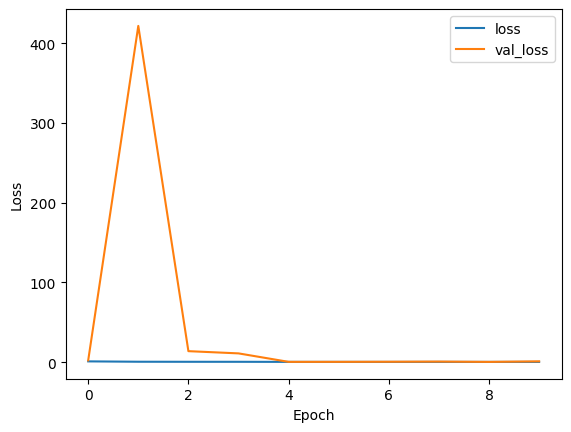

In [9]:
plot_loss(history)

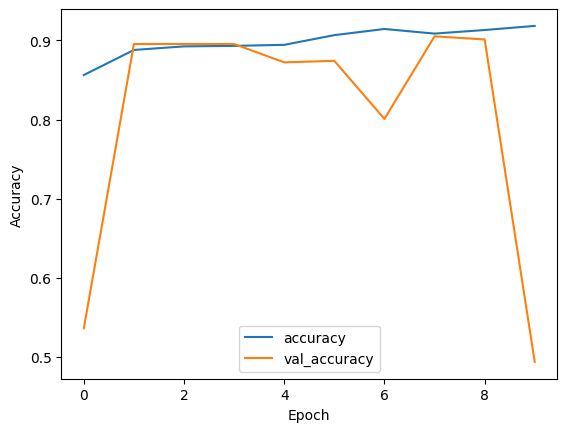

In [12]:
plot_accuracy(history)

In [ ]:
y_true, y_pred = predict_test_data(base_model, test_ds)
make_classification_report(y_true, y_pred)
make_confusion_matrix(y_true, y_pred)

In [15]:
base_model.save('./models/PlainResNet50.keras')

## Pretrained model

Use the weights that were obtained by training on the imagenet dataset. All other parameters stay the same to really compare two models.

In [26]:
def build_pretrained_model():
    base_architecture = ResNet50(include_top=False, weights='imagenet', input_shape=(224, 224, 3), classes=len(class_names), pooling='avg') # pooling None, avg or max?
    
    base_architecture.trainable = False # no need to re-train these layers
    
    model = tf.keras.models.Sequential()
    model.add(base_architecture)
    model.add(tf.keras.layers.Flatten())
    model.add(tf.keras.layers.Dense(512, activation='relu'))
    model.add(tf.keras.layers.Dense(len(class_names), activation='softmax'))

    model.compile(
        optimizer=Adam(learning_rate=0.001),
        loss='categorical_crossentropy',
        metrics=['accuracy']
    )
    return model


pretrained_model = build_pretrained_model()
pretrained_model.summary()

Model: "sequential_6"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ resnet50 (Functional)           │ (None, 2048)           │    23,587,712 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_6 (Flatten)             │ (None, 2048)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_10 (Dense)                │ (None, 512)            │     1,049,088 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_11 (Dense)                │ (None, 3)              │         1,539 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 24,638,339 (93.99 MB)

 Trainable params: 1,050,627 (4.01 MB)

 Non-trainable params: 23,587,712 (89.98 MB)

In [24]:
pretrained_history = pretrained_model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=10 # train until converging? accuracy is already good
)

Epoch 1/10
49/49 ━━━━━━━━━━━━━━━━━━━━ 167s 3s/step - accuracy: 0.8861 - loss: 0.6372 - val_accuracy: 0.9787 - val_loss: 0.0541
Epoch 2/10
49/49 ━━━━━━━━━━━━━━━━━━━━ 233s 4s/step - accuracy: 0.9857 - loss: 0.0424 - val_accuracy: 0.9749 - val_loss: 0.0854
Epoch 3/10
 1/49 ━━━━━━━━━━━━━━━━━━━━ 2:42 3s/step - accuracy: 1.0000 - loss: 0.0086

KeyboardInterrupt: 

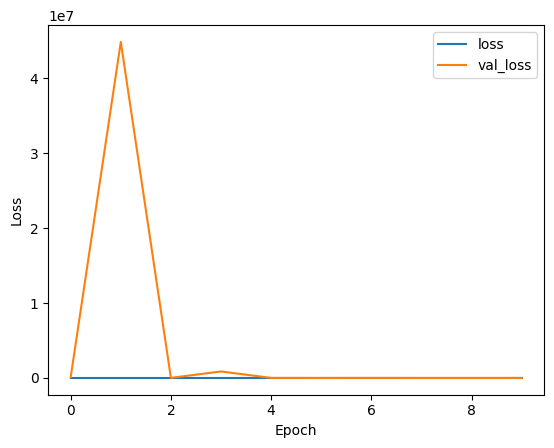

In [26]:
plot_loss(pretrained_history)

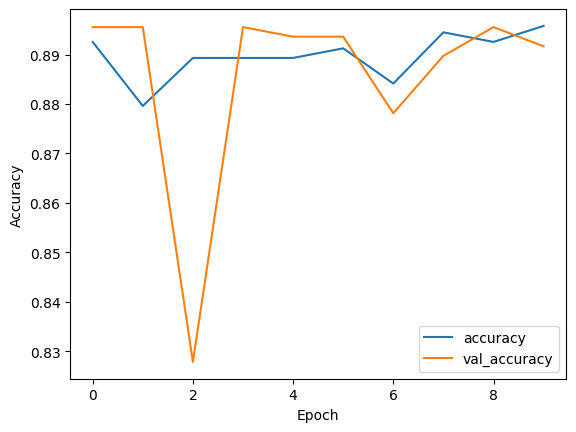

In [27]:
plot_accuracy(pretrained_history)

In [ ]:
y_true, y_pred = predict_test_data(pretrained_model, test_ds)
make_classification_report(y_true, y_pred)
make_confusion_matrix(y_true, y_pred)
pretrained_model.save('./models/PretrainedResNet50.keras')

## Data Augmentation

In [4]:
def visualize(original, augmented):
    fig = plt.figure(figsize=(8, 4))

    def prepare(img):
        # Ensure float32 and normalize only if needed
        if img.dtype != tf.uint8:
            img = tf.clip_by_value(img, 0, 255)
            img = tf.cast(img, tf.uint8)

        img = img.numpy()

        if img.shape[-1] == 1:
            return img.squeeze(), 'gray'
        else:
            return img, None

    orig_img, cmap1 = prepare(original)
    aug_img, cmap2 = prepare(augmented)

    plt.subplot(1, 2, 1)
    plt.title('Original image')
    plt.imshow(orig_img, cmap=cmap1)
    plt.axis('off')

    plt.subplot(1, 2, 2)
    plt.title('Augmented image')
    plt.imshow(aug_img, cmap=cmap2)
    plt.axis('off')

    plt.show()

In [5]:
# random zoom tf.image.central_crop
def zoom_img(image):
    rand = random.uniform(0.5, 1.0)
    zoomed = tf.image.central_crop(image, central_fraction=rand)
    return tf.image.resize(zoomed, (224, 224))

In [6]:
# random crop tf.image.stateless_random_crop
def crop_img(image):
    random_seed = (random.randint(0, 10000), random.randint(0, 10000))
    cropped = tf.image.stateless_random_crop(image, (112, 112, 3), seed=random_seed)
    return tf.image.resize(cropped, (224, 224))

In [7]:
# random translation (color) tf.image.rgb_to_grayscale
def grey_img(image):
    return tf.image.rgb_to_grayscale(image)

In [8]:
# rotation
def translate_img(image):
    rot = tf.image.rot90(image)
    return tf.image.resize(rot, (224, 224))

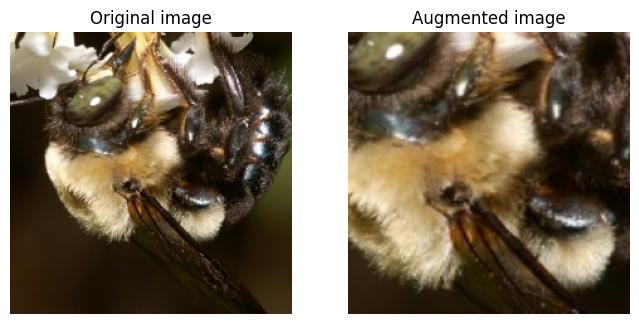

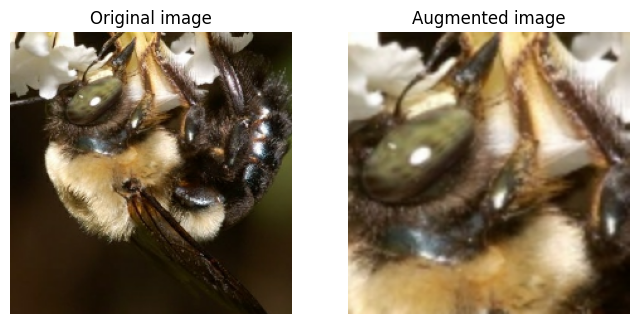

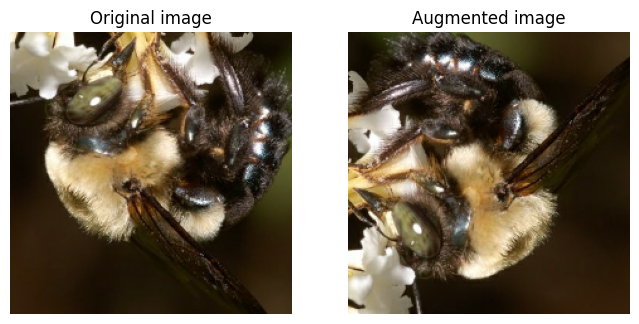

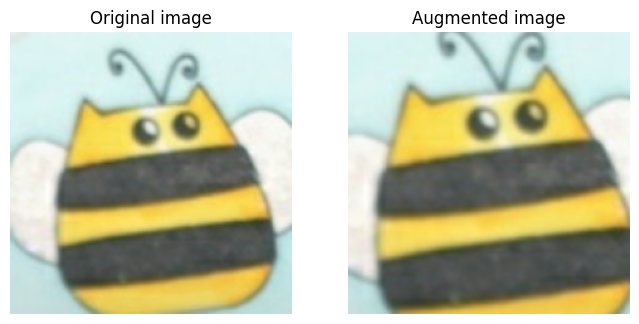

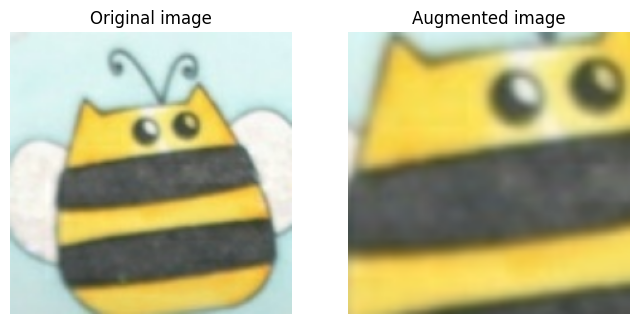

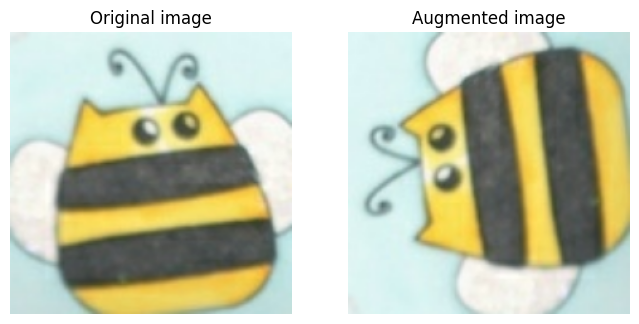

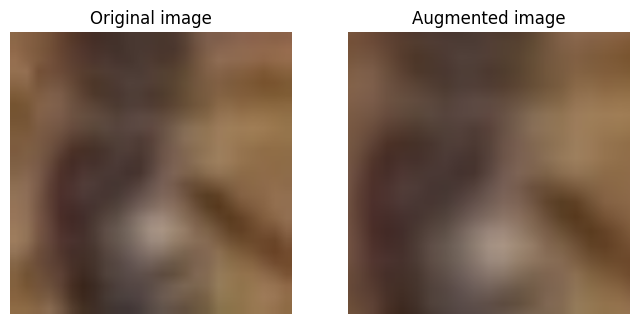

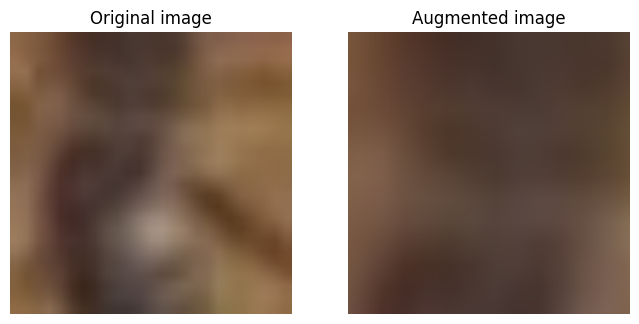

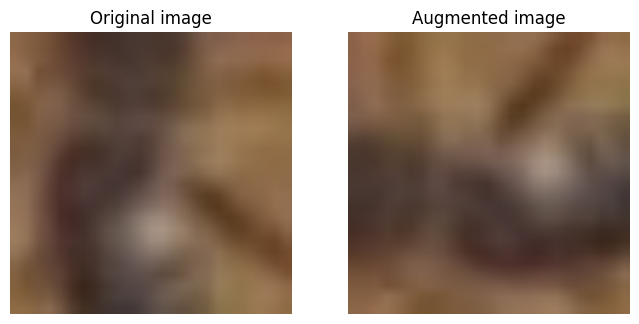

In [9]:
img_data = train_ds.unbatch()

for img, label in img_data.take(3):
    image = img
    aug_zoom = zoom_img(image)
    aug_crop = crop_img(image)
    aug_translate = translate_img(image)

    visualize(img, aug_zoom)
    visualize(img, aug_crop)
    visualize(img, aug_translate)

In [ ]:
# random left-right flip tf.image.flip_left_right

In [10]:
# augment_train_data(train_ds):
def apply_augmentation(dataset, aug_fn):
    def augment(image, label):
        image = aug_fn(image)
        return image, label
    return dataset.map(augment, num_parallel_calls=tf.data.AUTOTUNE)

In [11]:
def augment_data(ds, fractions=None):
    if fractions is None:
        fractions = {'zoom': 0.3, 'crop': 0.3, 'translate': 0.3}  # remaining 0.1 will be unaugmented

    # Unbatch dataset to access individual images
    unbatched = ds.unbatch()
    images, labels = [], []

    for img, label in unbatched:
        images.append(img)
        labels.append(label)

    total = len(images)
    idxs = list(range(total))
    random.shuffle(idxs)

    zoom_n = int(fractions['zoom'] * total)
    crop_n = int(fractions['crop'] * total)
    trans_n = int(fractions['translate'] * total)
    remain_n = total - (zoom_n + crop_n + trans_n)

    # Split indices
    zoom_idxs = idxs[:zoom_n]
    crop_idxs = idxs[zoom_n:zoom_n + crop_n]
    trans_idxs = idxs[zoom_n + crop_n:zoom_n + crop_n + trans_n]
    remain_idxs = idxs[zoom_n + crop_n + trans_n:]

    # Augment
    aug_images, aug_labels = [], []
    # add augmented data to unaugmented images
    for i in zoom_idxs:
        images.append(zoom_img(images[i]))
        labels.append(labels[i])

    for i in crop_idxs:
        images.append(crop_img(images[i]))
        labels.append(labels[i])

    for i in trans_idxs:
        images.append(translate_img(images[i]))
        labels.append(labels[i])

    for i in remain_idxs:
        images.append(images[i])
        labels.append(labels[i])

    # Create new dataset
    aug_ds = tf.data.Dataset.from_tensor_slices((images, labels))
    aug_ds = aug_ds.shuffle(1000).batch(batch_size)#.prefetch(tf.data.AUTOTUNE)

    return aug_ds

In [12]:
aug_train_ds = augment_data(train_ds)

#### Base Model with data augmentation

In [17]:
aug_base_model = ResNet50(include_top=True, weights=None, input_shape=(224, 224, 3), classes=len(class_names)) # include_top=True adds the classification layer

aug_base_model.compile(
    optimizer=Adam(),
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

aug_history = aug_base_model.fit(
    aug_train_ds,
    validation_data=val_ds,
    epochs=10
)

Epoch 1/10
 2/97 ━━━━━━━━━━━━━━━━━━━━ 16:29 10s/step - accuracy: 0.2188 - loss: 2.6513      

Exception ignored in: 'zmq.backend.cython._zmq.Frame.__del__'
Traceback (most recent call last):
  File "_zmq.py", line 160, in zmq.backend.cython._zmq._check_rc
KeyboardInterrupt: 


KeyboardInterrupt: 

In [ ]:
plot_loss(aug_history)
plot_accuracy(aug_history)

In [ ]:
y_true, y_pred = predict_test_data(aug_base_model, test_ds)
make_classification_report(y_true, y_pred)
make_confusion_matrix(y_true, y_pred)
aug_base_model.save('./models/AugPlainResNet50.keras')

#### Pre-trained model with data augmentation

In [ ]:
aug_pretrained_model = build_pretrained_model()
aug_pretrained_history = aug_pretrained_model.fit(
    aug_train_ds,
    validation_data=val_ds,
    epochs=10
)

In [ ]:
plot_loss(aug_pretrained_history)
plot_accuracy(aug_pretrained_history)

In [ ]:
y_true, y_pred = predict_test_data(aug_pretrained_model, test_ds)
make_classification_report(y_true, y_pred)
make_confusion_matrix(y_true, y_pred)
aug_base_model.save('./models/AugPretrainedResNet50.keras')